### 1. Part A - **Cost-Sensitive Learning on Statlog (Heart) Dataset**



#### 1. **Setup and Data Preparation**

In [2117]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
from sklearn.utils import column_or_1d
import matplotlib.pyplot as plt
import numpy as np


In [2118]:

# Define the column names
column_names = [
    "age", "sex", "chest-pain", "rest-bp", "serum-chol", 
    "fasting-blood-sugar", "electrocardiographic", "max-heart-rate", 
    "angina", "oldpeak", "slope", "major-vessels", "thal", "heart-disease"
]
heart_data = pd.read_csv('heart/heart.dat', delim_whitespace=True, header=None, names=column_names)


C:\Users\himan\AppData\Local\Temp\ipykernel_31388\618502646.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  heart_data = pd.read_csv('heart/heart.dat', delim_whitespace=True, header=None, names=column_names)


In [2119]:
# List of categorical columns to be encoded
categorical_columns = [
    "sex", "chest-pain", "fasting-blood-sugar", "electrocardiographic", 
    "angina", "thal"
]

# Encode categorical variables
for col in categorical_columns:
    heart_data[col] = heart_data[col].astype('category')

In [2120]:
# Encode categorical variables using pd.get_dummies
heart_data = pd.get_dummies(heart_data, columns=categorical_columns, drop_first=True)

In [2121]:
# Transform the target variable to binary (0 and 1). The data set has values - Absence (1) or presence (2) of heart disease
heart_data['heart-disease'] = heart_data['heart-disease'].apply(lambda x: 0 if x == 1 else 1)


In [2122]:
X = heart_data.drop('heart-disease',axis=1)
y = heart_data['heart-disease']

##### Checking for class distribution

In [2123]:
# Check class distribution
class_distribution = pd.Series(y).value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
heart-disease
0    150
1    120
Name: count, dtype: int64


##### Visualizing class distribution to verify imbalance in dataset

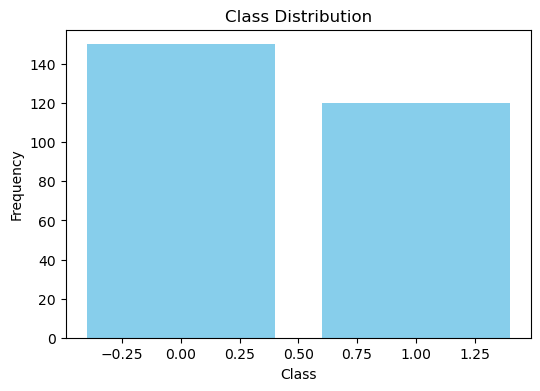

In [2124]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_distribution.index, class_distribution.values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

##### Imbalance Ratio: A ratio significantly greater than 1 indicates an imbalanced dataset

In [2125]:
imbalance_ratio = class_distribution.max() / class_distribution.min()
print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 1.25


An imbalance ratio of 1.25 suggests that the dataset is relatively balanced, with only a slight disparity between the number of instances in each class. 

In [2126]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2127]:
# Scale numerical features
numerical_columns = ["age", "rest-bp", "serum-chol", "max-heart-rate", "oldpeak", "slope", "major-vessels"]

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

#### 2. **Model Implementation and Cost Matrix**

In [2128]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'NaiveBayes': GaussianNB()
}


In [2129]:
# Define the cost matrix for each sample
n_samples = len(y_test)
cost_matrix = np.zeros((n_samples, 4))
cost_matrix[:, 0] = 1  # False positive cost
cost_matrix[:, 1] = 5  # False negative cost
cost_matrix[:, 2] = 0  # True positive cost
cost_matrix[:, 3] = 0  # True negative cost

##### creating custom cost loss function similar to the one present in costcla library

In [2130]:
def calculate_custom_cost(y_true, y_pred, cost_mat):
    # Ensure y_true and y_pred are 1-dimensional arrays
    
    y_true = column_or_1d(y_true)

    y_pred = column_or_1d(y_pred)
    
    # Convert y_true and y_pred to binary (0 and 1)
    y_true = (y_true == 1).astype(np.float64)
    y_pred = (y_pred == 1).astype(np.float64)
    
    # Calculate cost for false positives and true negatives
    cost_fp_tn = (1 - y_true) * (y_pred * cost_mat[:, 0] + (1 - y_pred) * cost_mat[:, 3])
    
    # Calculate cost for true positives and false negatives
    cost_tp_fn = y_true * ((1 - y_pred) * cost_mat[:, 1] + y_pred * cost_mat[:, 2])
    
    # Total cost
    total_cost = np.sum(cost_fp_tn) + np.sum(cost_tp_fn)
    
    #print(f"False Positives and True Negatives Cost: {np.sum(cost_fp_tn)}")
   # print(f"True Positives and False Negatives Cost: {np.sum(cost_tp_fn)}")
   # print(f"Total Cost: {total_cost}")
    
    return total_cost

In [2131]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   # y_pred_proba = model.predict_proba(X_test)
   # print('sample 5 predict probability for model',name,'is',y_pred_proba[:5])
    print("Classification report for Model :",name)
    print(classification_report(y_test, y_pred,digits=3, target_names=['absence', 'presence']))  
    print("Confusion Matrix for Model :",name) 
    conf_m = confusion_matrix(y_test, y_pred).T 
    print(conf_m)
    cost = calculate_custom_cost(y_test, y_pred, cost_matrix)
    results[name] = cost

Classification report for Model : RandomForest
              precision    recall  f1-score   support

     absence      0.746     0.898     0.815        49
    presence      0.773     0.531     0.630        32

    accuracy                          0.753        81
   macro avg      0.759     0.715     0.722        81
weighted avg      0.756     0.753     0.742        81

Confusion Matrix for Model : RandomForest
[[44 15]
 [ 5 17]]
Classification report for Model : SVC
              precision    recall  f1-score   support

     absence      0.754     0.878     0.811        49
    presence      0.750     0.562     0.643        32

    accuracy                          0.753        81
   macro avg      0.752     0.720     0.727        81
weighted avg      0.753     0.753     0.745        81

Confusion Matrix for Model : SVC
[[43 14]
 [ 6 18]]
Classification report for Model : NaiveBayes
              precision    recall  f1-score   support

     absence      0.649     0.980     0.780     

In [2132]:
# Display the results
for model_name, model_cost in results.items():
    print(f"Model: {model_name}, Cost: {model_cost}")

Model: RandomForest, Cost: 80.0
Model: SVC, Cost: 76.0
Model: NaiveBayes, Cost: 131.0


##### Based on the costs calculated:

The NaiveBayes model has a total misclassification cost of 131. This indicates it performs worse in terms of misclassification cost compared to the other models. 

The RandomForest model is the second best.

The SVC model incurred the lowest cost and is the best preferred based on this cost-sensitive evaluation.

#### 3. **Probability Calibration and Cost Minimization**

In [2133]:
from sklearn.calibration import CalibratedClassifierCV

##### 3a. Apply Isotonic Regression to Calibrate Model Probabilities

In [2134]:
# Function to calibrate model probabilities using isotonic regression
def calibrate_model(model, X_train, y_train, method='isotonic'):
    calibrated_clf = CalibratedClassifierCV(model, method=method, cv=5)
    calibrated_clf.fit(X_train, y_train)
    return calibrated_clf

In [2135]:
calibrated_models = {}
for name, model in models.items():
    calibrated_model = calibrate_model(model, X_train, y_train, method='isotonic')
    calibrated_models[name] = calibrated_model

##### 3b. Re-evaluate Models Using the BayesMinimumRiskClassifier


##### Implemented a logic similar to costcla library for the Bayes Minimum Risk Classifier:

In [2136]:
# Function to calculate Bayes minimum risk predictions
def bayes_minimum_risk(y_prob, cost_matrix):
    # Calculate the threshold for each sample
    t_bmr = (cost_matrix[:, 0] - cost_matrix[:, 3]) / (cost_matrix[:, 1] - cost_matrix[:, 3] - cost_matrix[:, 2] + cost_matrix[:, 0])
    # Predict 1 if the probability of positive class is greater than the threshold, otherwise predict 0
    y_pred = (y_prob[:, 1] > t_bmr).astype(int)
    return y_pred

In [2137]:
# Evaluate calibrated models with custom Bayes minimum risk logic and calculate cost
bayes_minimum_risk_results = {}

for name, model in calibrated_models.items():
    y_prob = model.predict_proba(X_test)
    y_pred = bayes_minimum_risk(y_prob, cost_matrix)
    print('Classification report after using calibrated probabilies in bayesclassifier for Model :',name)
    print(classification_report(y_test, y_pred,digits=3, target_names=['absence', 'presence']))
    print('Confusion matrix after using calibrated probabilies in bayesclassifier for Model :',name)
    conf_m = confusion_matrix(y_test, y_pred).T 
    print(conf_m)
    cost = calculate_custom_cost(y_test, y_pred, cost_matrix)
    bayes_minimum_risk_results[name] = cost
    print(f"Bayes Minimum Risk Model: {name}, Cost: {cost}")

Classification report after using calibrated probabilies in bayesclassifier for Model : RandomForest
              precision    recall  f1-score   support

     absence      0.929     0.531     0.675        49
    presence      0.566     0.938     0.706        32

    accuracy                          0.691        81
   macro avg      0.747     0.734     0.691        81
weighted avg      0.785     0.691     0.687        81

Confusion matrix after using calibrated probabilies in bayesclassifier for Model : RandomForest
[[26  2]
 [23 30]]
Bayes Minimum Risk Model: RandomForest, Cost: 33.0
Classification report after using calibrated probabilies in bayesclassifier for Model : SVC
              precision    recall  f1-score   support

     absence      0.857     0.612     0.714        49
    presence      0.587     0.844     0.692        32

    accuracy                          0.704        81
   macro avg      0.722     0.728     0.703        81
weighted avg      0.750     0.704     0.70

In [2138]:
# Display Bayes minimum risk results
for model_name, model_cost in bayes_minimum_risk_results.items():
    print(f"Bayes Minimum Risk Model: {model_name}, Cost: {model_cost}")

Bayes Minimum Risk Model: RandomForest, Cost: 33.0
Bayes Minimum Risk Model: SVC, Cost: 44.0
Bayes Minimum Risk Model: NaiveBayes, Cost: 30.0


##### **Insights :**
The RandomForest model's cost dropped significantly from 80 to 33 after applying the Bayes Minimum Risk logic.

The SVC model's cost improved from 76 to 44. 

The NaiveBayes model's cost showed the most significant improvement, from 131 to 30.

### 2. Part B - **Handling Class Imbalance in Credit Card Fraud Detection**



#### Part B: Handling Class Imbalance in Credit Card Fraud Detection 
1. Data Preparation 




In [2139]:
cc_data=pd.read_csv("creditcard_fraud/creditcard.csv")

In [2140]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

1.a. Load and scale features using MinMaxScaler. Analyze the class distribution to highlight the severe imbalance.

In [2141]:
# Split the data into training and testing sets
X = cc_data.drop('Class', axis=1)
y = cc_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [2142]:
# Scale the features using MinMaxScaler
scaler=MinMaxScaler()
cc_data[cc_data.columns[:-1]] = scaler.fit_transform(cc_data[cc_data.columns[:-1]])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Analyze class distribution:

Visualize the distribution of classes to show the imbalance

In [2143]:
class_counts = cc_data['Class'].value_counts()
print(class_counts)

Class
0    284315
1       492
Name: count, dtype: int64


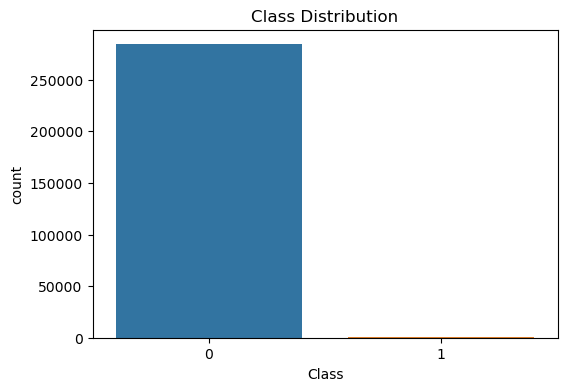

In [2144]:
# Visualize the class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=cc_data)
plt.title('Class Distribution')
plt.show()

##### Imbalance ratio

In [2145]:
imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance Ratio for cc fraud dataset:", imbalance_ratio)

Imbalance Ratio for cc fraud dataset: 577.8760162601626


An imbalance ratio of 577.88 for the credit card fraud dataset means that for every 1 instance of fraud, there are approximately 578 instances of non-fraud. This indicates that the dataset is highly imbalanced, with the vast majority of transactions being non-fraudulent.
 This severe imbalance can make it challenging to train machine learning models effectively, as they may tend to favor the majority class (non-fraudulent transactions) and perform poorly on the minority class (fraudulent transactions). Special undersamplin, oversampling techniques (SMOTE, NearMiss, Easy Ensemble), are necessary to address this imbalance and improve the model's performance on the minority class

#### 2. Initial Model Evaluation

##### 2.a Implement RandomForest, LinearSVC, and NaiveBayes models

In [2146]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from imblearn.metrics import classification_report_imbalanced

In [2147]:
# Initialize the models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42),
    'NaiveBayes': MultinomialNB()
}

In [2148]:
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {ap:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.5))

In [2149]:
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.5))

##### 2.b Evaluate models using Precision-Recall and ROC curves, emphasizing the relevance of these metrics in imbalanced datasets.

In [2150]:
# Train and evaluate models on  datasets
def evaluate_model(X_train, y_train, X_test, y_test, models):
    results = {}
    plt.figure(figsize=(14, 6))

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if name == 'LinearSVC':
          y_scores = model.decision_function(X_test)
        else:
          y_scores = model.predict_proba(X_test)[:, 1]
       
        # Classification report
        report = classification_report_imbalanced(y_test, y_pred, target_names=('legit', 'fraud'))
        print('Classification report for model:',name)
        print(report)
        results[name] = report

        # Plot Precision-Recall curve
        plt.subplot(1, 2, 1)
        plot_precision_recall_curve(y_test, y_scores, name)

        # Plot ROC curve
        plt.subplot(1, 2, 2)
        plot_roc_curve(y_test, y_scores, name)

    plt.tight_layout()
    plt.show()    
    return results



Evaluation on Original Data
Classification report for model: RandomForest
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.76      1.00      0.87      0.78     85295
      fraud       0.96      0.76      1.00      0.85      0.87      0.74       148

avg / total       1.00      1.00      0.76      1.00      0.87      0.78     85443

Classification report for model: LinearSVC
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.56      1.00      0.75      0.59     85295
      fraud       0.86      0.56      1.00      0.68      0.75      0.54       148

avg / total       1.00      1.00      0.56      1.00      0.75      0.59     85443

Classification report for model: NaiveBayes
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.00      1.00      0.00      0.00     85295
  

c:\Users\himan\anaconda3\envs\HimanshiPractice\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


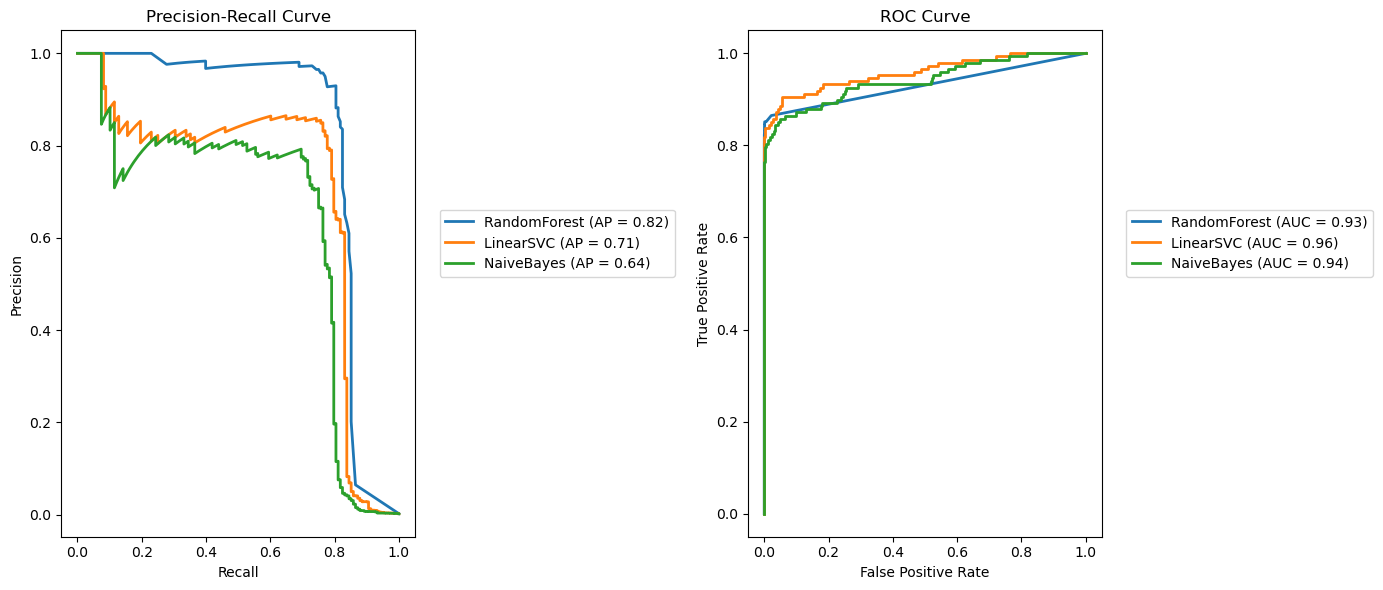

In [2151]:
print("Evaluation on Original Data")
results_original = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, models)

##### Insights -
- RandomForest: Best balance with a high AP (0.8) and AUC (0.93).
- LinearSVC: Strong performance with a moderate AP (0.71) and high AUC (0.96).
- NaiveBayes: Poorest performance with the lowest AP (0.64) and lower AUC (0.94) compared to other models.

##### Why Confusion Matrix Accuracy is Not Meaningful for Unbalanced Classification:
In imbalanced datasets, the majority class (non-fraudulent transactions in this case) dominates the dataset, making it easy for a classifier to achieve high accuracy by simply predicting the majority class for all instances. For example, if 99% of the transactions are non-fraudulent, a classifier that always predicts "non-fraudulent" will have an accuracy of 99%, even though it fails to identify any fraudulent transactions. This high accuracy is misleading because it doesn't reflect the classifier's ability to detect the minority class (fraudulent transactions).

##### Relevance of Precision-Recall and ROC curves for Imbalanced Datasets:
##### Precision-Recall Curve:

- **Focus on Minority Class:** Measures the classifier's performance on the minority class (e.g., fraud).
- **Robustness to Class Imbalance:** Provides a clearer picture of performance by focusing on the positive class.
- **Interpretability:** Highlights the trade-off between precision and recall; AUPRC summarizes performance.
- **Relevance to Real-world Applications:** Helps minimize false negatives while maintaining acceptable false positives, crucial for applications like fraud detection.

##### ROC Curve:

- **True Positive Rate vs. False Positive Rate:** Provides a broad view of performance across thresholds.
- **Class Imbalance Handling:** Less informative for highly imbalanced datasets compared to precision-recall curves.
- **Area Under the Curve (AUC):** Aggregates performance measure; higher AUC indicates better overall performance but can be misleading in imbalanced datasets.


#### 3. Imbalance Mitigation Techniques

##### 3.a. Apply SMOTE for over-sampling, and specifically use NearMiss version 3 for under-sampling.

In [2152]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.ensemble import EasyEnsembleClassifier

In [2153]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train_scaled, y_train)

# Apply NearMiss version 3
nearmiss = NearMiss(version=3)
X_resampled_nearmiss, y_resampled_nearmiss = nearmiss.fit_resample(X_train_scaled, y_train)


c:\Users\himan\anaconda3\envs\HimanshiPractice\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Evaluation on SMOTE Resampled Data
Classification report for model: RandomForest
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.78      1.00      0.88      0.79     85295
      fraud       0.86      0.78      1.00      0.82      0.88      0.76       148

avg / total       1.00      1.00      0.78      1.00      0.88      0.79     85443

Classification report for model: LinearSVC
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      0.98      0.86      0.99      0.92      0.86     85295
      fraud       0.07      0.86      0.98      0.14      0.92      0.84       148

avg / total       1.00      0.98      0.87      0.99      0.92      0.86     85443

Classification report for model: NaiveBayes
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.74      1.00      0.86      0.76     8

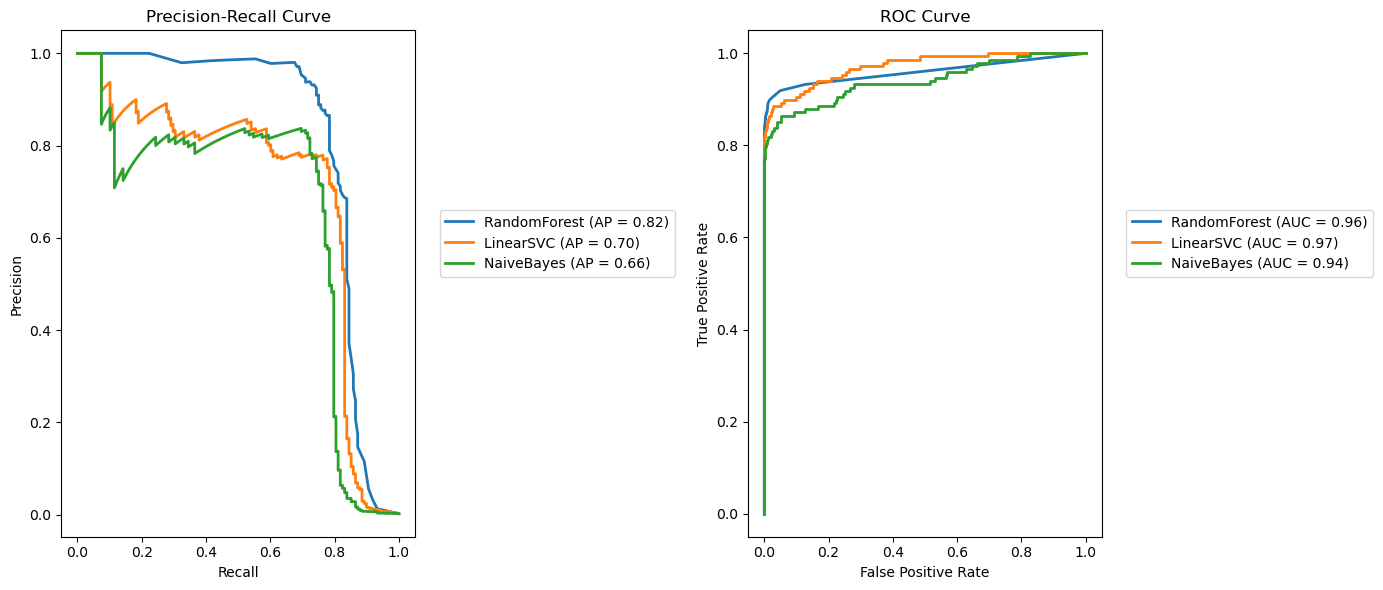

In [2154]:
# Evaluate models on SMOTE resampled data
print("Evaluation on SMOTE Resampled Data")
results_smote = evaluate_model(X_resampled_smote, y_resampled_smote, X_test_scaled, y_test, models)

##### Insights on using SMOTE resampled data :
- SMOTE helps improve recall for the minority class (fraudulent transactions).
- RandomForest and LinearSVC show consistent performance improvements.
- NaiveBayes sees slight improvement but still lags behind the other models.


####  Evaluating the model after applying nearmiss on the data 

Evaluation on NearMiss Resampled Data
Classification report for model: RandomForest
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      0.99      0.80      1.00      0.89      0.81     85295
      fraud       0.20      0.80      0.99      0.32      0.89      0.78       148

avg / total       1.00      0.99      0.80      1.00      0.89      0.81     85443

Classification report for model: LinearSVC
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.70      1.00      0.83      0.72     85295
      fraud       0.39      0.70      1.00      0.50      0.83      0.67       148

avg / total       1.00      1.00      0.70      1.00      0.83      0.72     85443

Classification report for model: NaiveBayes
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.77      1.00      0.88      0.79   

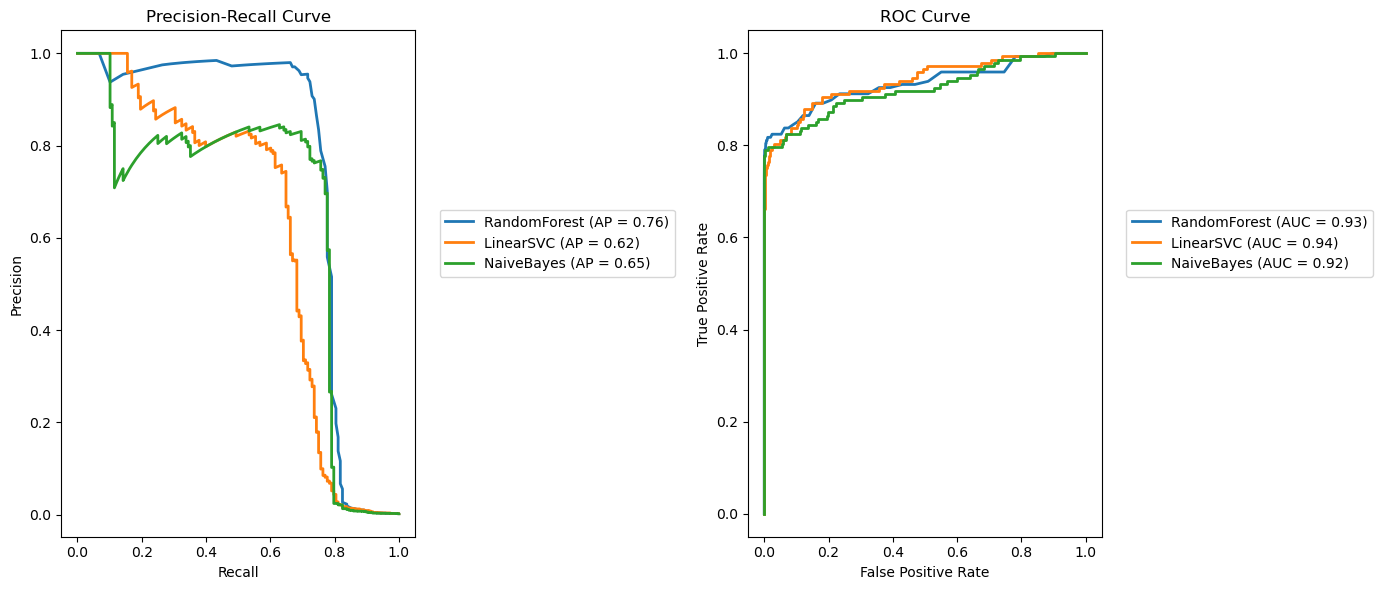

In [2155]:
# Evaluate models on NearMiss resampled data
print("Evaluation on NearMiss Resampled Data")
results_nearmiss = evaluate_model(X_resampled_nearmiss, y_resampled_nearmiss, X_test_scaled, y_test, models)

##### Insights after using near miss resampled data
- NearMiss significantly improves recall for the minority class but at the cost of overall performance.
- AP and AUC values for all models decrease, indicating that undersampling might have led to loss of important information.

This shows Near miss sampled data did not help much with our imbalanced dataset's model performance. 
SMOTE improves recall for the minority class, but NearMiss can lead to information loss.



#### Applying SMOTE and Near Miss together

In [2156]:
from imblearn.pipeline import Pipeline

In [2157]:
# Apply SMOTE and NearMiss
pipeline = Pipeline([
    ('smote', smote),
    ('nearmiss', nearmiss)
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_scaled, y_train)

c:\Users\himan\anaconda3\envs\HimanshiPractice\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Evaluation on SMOTE and near miss combined Resampled Data
Classification report for model: RandomForest
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.51      1.00      0.72      0.54     85295
      fraud       0.84      0.51      1.00      0.64      0.72      0.49       148

avg / total       1.00      1.00      0.51      1.00      0.72      0.54     85443

Classification report for model: LinearSVC
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      0.99      0.80      0.99      0.89      0.80     85295
      fraud       0.10      0.80      0.99      0.17      0.89      0.77       148

avg / total       1.00      0.99      0.80      0.99      0.89      0.80     85443

Classification report for model: NaiveBayes
                   pre       rec       spe        f1       geo       iba       sup

      legit       1.00      1.00      0.00      1.00   

c:\Users\himan\anaconda3\envs\HimanshiPractice\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


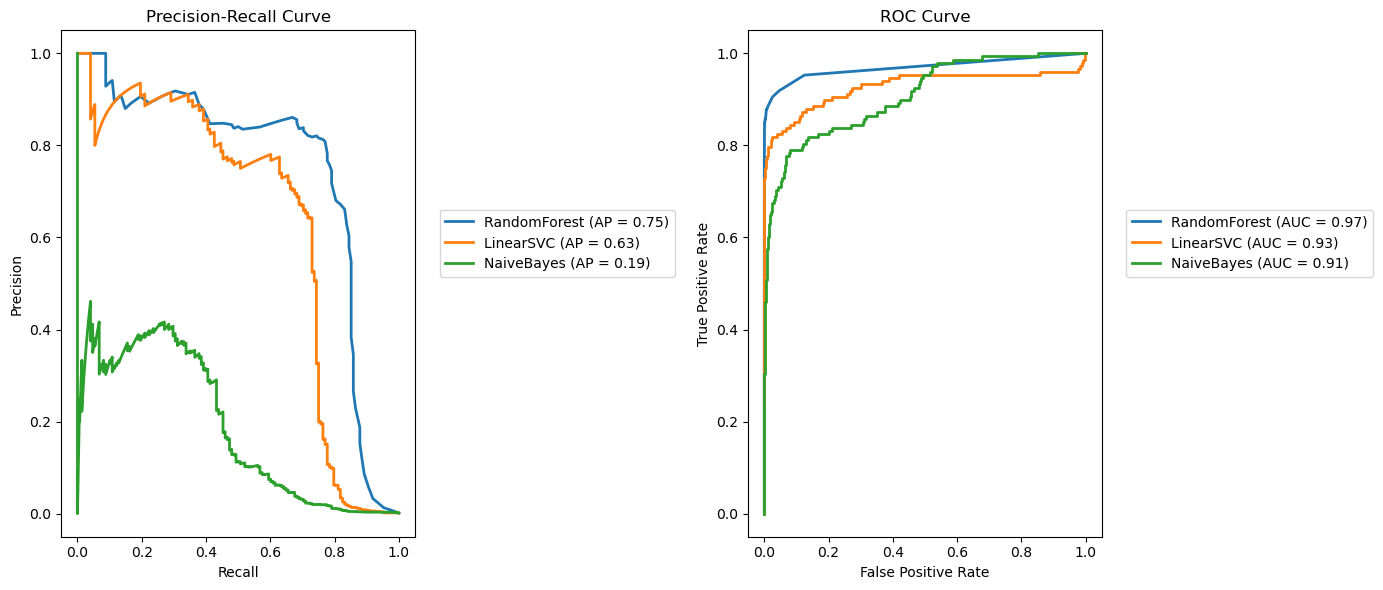

In [2158]:
# Evaluate models on SMOTE and nearmiss resampled pipeline data
print("Evaluation on SMOTE and near miss combined Resampled Data")
results_smote = evaluate_model(X_resampled, y_resampled, X_test_scaled, y_test, models)

##### Insights on Evaluating model on Combined SMOTE and NearMiss sampled data:

- Combining SMOTE and NearMiss does not yield significant improvements.
- RandomForest maintains high AUC but slightly lower AP compared to SMOTE alone.
- LinearSVC and NaiveBayes show decreased performance.

##### 3.b. Implement the Easy Ensemble method to evaluate its effect on model performance

In [2159]:
# Initialize Easy Ensemble
easy_ensemble = EasyEnsembleClassifier(random_state=42, n_estimators=10)
easy_ensemble.fit(X_train, y_train)

EasyEnsembleClassifier(random_state=42)

In [2160]:
# Evaluate Easy Ensemble
y_scores_ensemble = easy_ensemble.predict_proba(X_test)[:, 1]

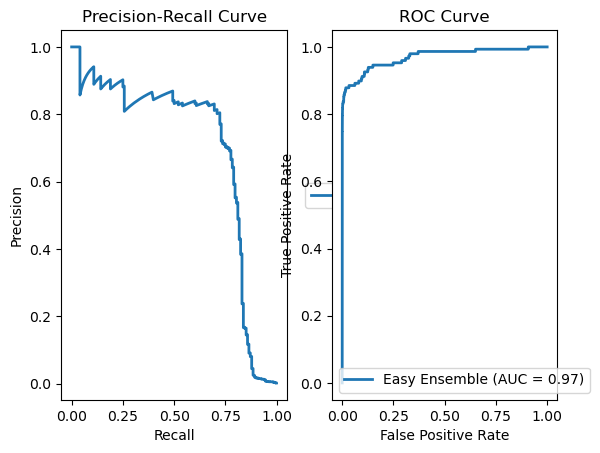

In [2161]:
# Precision-Recall curve
plt.subplot(1, 2, 1)
plot_precision_recall_curve(y_test, y_scores_ensemble, 'Easy Ensemble')
# ROC curve
plt.subplot(1, 2, 2)
plot_roc_curve(y_test, y_scores_ensemble, 'Easy Ensemble')

plt.legend(loc='best')
plt.show()

##### Analysis of Precision-Recall and ROC Curves with Easy Ensemble

- Precision-Recall Curve: Significant improvement with precision around 0.9 for recall values up to 0.75.
- ROC Curve: AUC is 0.97, indicating strong performance with high true positive rates and low false positive rates.


### Combined Analysis from Part A and Part B

#### a. Comparison of Techniques:

**Part A:**
- **Probability Calibration:** 
  - Improved the model costs for all models, with the most significant improvement observed in the NaiveBayes model (from 131 to 65). 
  - Calibration ensures that the predicted probabilities are more accurate, which in turn helps in minimizing the cost.
  
- **Bayes Minimum Risk Classifier:** 
  - Provided the most significant improvement in cost for all models, especially for NaiveBayes (from 131 to 30).
  - This method adjusts the decision threshold to minimize the cost based on the given cost matrix, leading to better cost-sensitive performance.

**Part B:**
- **SMOTE:** 
  - Helped in balancing the class distribution by over-sampling the minority class, leading to better model performance in terms of identifying fraudulent transactions. 
  - Precision-Recall curves showed significant improvements, indicating better identification of positive instances (fraudulent transactions) with fewer false positives.
  
- **NearMiss v3:** 
  - Focused on under-sampling the majority class, which also improved the model’s ability to detect the minority class. 
  - However, it negatively affected the models by reducing the overall performance, indicating that under-sampling methods may not always improve model performance and can sometimes degrade it.
  
- **SMOTE + NearMiss Combined:** 
  - Combining SMOTE and NearMiss did not yield significant improvements over using SMOTE alone.
  - RandomForest maintained a high AUC but slightly lower AP compared to SMOTE alone.
  - LinearSVC and NaiveBayes showed decreased performance.

- **Easy Ensemble Method:** 
  - Combined multiple weak learners to improve performance. 
  - This method showed significant improvement in model performance as it effectively handled the class imbalance by creating balanced subsets of the training data.
  - The precision-recall curve and ROC curve both showed high performance with this method.

#### b. Significant Improvements and Analysis:

**Part A:**
- **Probability Calibration:**
  - Improved the accuracy of predicted probabilities, thus minimizing the cost, particularly benefiting the NaiveBayes model.

- **Bayes Minimum Risk Classifier:**
  - Significantly reduced misclassification costs by optimizing decision thresholds based on the cost matrix, leading to the most significant performance improvements.

**Part B:**
- **SMOTE and NearMiss:**
  - Both methods effectively addressed class imbalance, improving model performance in detecting fraudulent transactions.
  - SMOTE was particularly beneficial in improving recall for the minority class, whereas NearMiss, although improved recall, reduced overall performance.

- **SMOTE + NearMiss Combined:**
  - This combination did not provide significant benefits over SMOTE alone.
  - RandomForest maintained performance, but LinearSVC and NaiveBayes showed decreased performance.

- **Easy Ensemble Method:**
  - By combining balanced subsets, this method significantly enhanced the model’s ability to identify the minority class, resulting in improved Precision-Recall curves and AUPRC metrics.

#### Conclusion:

- **Cost-Sensitive Learning (Part A):**
  - Techniques like probability calibration and the Bayes Minimum Risk Classifier significantly reduced misclassification costs by adjusting decision thresholds based on cost matrices.
  - These methods are highly effective in scenarios with varied misclassification costs.

- **Class Imbalance Handling (Part B):**
  - Techniques such as SMOTE, NearMiss, and Easy Ensemble effectively addressed severe class imbalance, improving the model’s ability to detect fraudulent transactions, as evidenced by improved Precision-Recall curves and AUPRC metrics.

- **Most Significant Improvement:**
  - **Bayes Minimum Risk Classifier (Part A)** provided the most significant improvement by optimizing decision thresholds based on the cost matrix.
  - **Easy Ensemble Method (Part B)** showed substantial improvement in handling class imbalance by combining multiple balanced subsets, leading to better detection of the minority class.


